# Оценка эффективности работы сети строительных магазинов

## 1. Обзор

**Импорты**

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import warnings
warnings.filterwarnings('ignore')

**Апдейты**

In [2]:
#pip install -U seaborn

**Данные**

In [3]:
product_price = pd.read_csv('product_codes.csv')
df = pd.read_csv('retail_dataset.csv')

**Обзор: Основной датасэт**

In [4]:
df.head()

,purchaseid,item_ID,Quantity,purchasedate,CustomerID,ShopID,loyalty_program
0,538280,21873,11,2016-12-10 12:50:00,18427.0,Shop 0,0.0
1,538862,22195,0,2016-12-14 14:11:00,22389.0,Shop 0,1.0
2,538855,21239,7,2016-12-14 13:50:00,22182.0,Shop 0,1.0
3,543543,22271,0,2017-02-09 15:33:00,23522.0,Shop 0,1.0
4,543812,79321,0,2017-02-13 14:40:00,23151.0,Shop 0,1.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105335 entries, 0 to 105334
Data columns (total 7 columns):
purchaseid         105335 non-null object
item_ID            105335 non-null object
Quantity           105335 non-null int64
purchasedate       105335 non-null object
CustomerID         69125 non-null float64
ShopID             105335 non-null object
loyalty_program    105335 non-null float64
dtypes: float64(2), int64(1), object(4)
memory usage: 5.6+ MB


Что сделать:
- Удобные названия столбцов
- Дату в дейттайм
- Пропуски в customer_id
- Тип данных в столбце customer_id
- Столбец ShopID к нижнему регистру
- Тип данных в loaylty_programm
- Дубликаты

**Обзор: Цены продуктов**

In [6]:
product_price.head()

,productID,price_per_one
0,85123A,2.55
1,71053,3.39
2,84406B,2.75
3,84029G,3.39
4,84029E,3.39


In [7]:
product_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9969 entries, 0 to 9968
Data columns (total 2 columns):
productID        9969 non-null object
price_per_one    9969 non-null float64
dtypes: float64(1), object(1)
memory usage: 155.9+ KB


Что сделать:
- Названия столбцов
- Дубликаты

## 2. Предобработка

**Основной датасэт**

In [8]:
#удобные названия столбцов
df.columns = ['purchase_id', 'product_id', 'quantity', 'purchase_dt', 'customer_id', 'shop_id', 'loyal']

In [9]:
#Дату в дейттайм
df['purchase_dt'] = pd.to_datetime(df['purchase_dt'], format='%Y-%m-%d %H:%M:%S')

Проверим, нет ли вдруг дробных значений в столбце loyal. Если нет, то переведем его в int.

In [10]:
df['loyal'].unique()

array([0., 1.])

In [11]:
#Тип данных в loaylty_programm
df['loyal'] = df['loyal'].astype('int')

In [12]:
#для удобства переведем в нижний регистр
df['shop_id'] = df['shop_id'].str.lower()

В столбце customer_id много пропусков. Видимо дело в том, что не у всех есть карта магазина, а без неё нет и id покупателя. Восстановить их никак не получится, поэтому оставим как есть. Проверим, нет ли дробных значений в столбце customer_id. Если нет, то переведем его в int.

In [13]:
df[df['customer_id'] % 1 > 0]['customer_id'].sum()

0.0

In [14]:
df['customer_id'] = df['customer_id'].astype('Int64')

In [15]:
print('Дубликатов в таблице:', df.duplicated().sum())

Дубликатов в таблице: 1033


Дубликатов много и это не похоже на ошибку в данных. Скорее всего таким образом просто пробили товар. Поскольку каждая строчка - это товар в чеке, то вполне можно представить как в одном чеке два раза пробивают один и тот же товар с одинаковым количеством (два раза по 10 досок, вместо одной позиции на 20 досок). Поэтому, удалять их мы не будем. 

Данные после предобработки

In [16]:
df.head()

,purchase_id,product_id,quantity,purchase_dt,customer_id,shop_id,loyal
0,538280,21873,11,2016-12-10 12:50:00,18427,shop 0,0
1,538862,22195,0,2016-12-14 14:11:00,22389,shop 0,1
2,538855,21239,7,2016-12-14 13:50:00,22182,shop 0,1
3,543543,22271,0,2017-02-09 15:33:00,23522,shop 0,1
4,543812,79321,0,2017-02-13 14:40:00,23151,shop 0,1


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105335 entries, 0 to 105334
Data columns (total 7 columns):
purchase_id    105335 non-null object
product_id     105335 non-null object
quantity       105335 non-null int64
purchase_dt    105335 non-null datetime64[ns]
customer_id    69125 non-null Int64
shop_id        105335 non-null object
loyal          105335 non-null int64
dtypes: Int64(1), datetime64[ns](1), int64(2), object(3)
memory usage: 5.7+ MB


**Датасэт с ценами продуктов**

In [18]:
product_price.columns = ['product_id', 'price']

In [19]:
print('Дубликатов в таблице:', product_price.duplicated().sum())

Дубликатов в таблице: 0


А что если есть дубликаты только в product_id? Проверим. 

In [20]:
print('Дубликатов по ID продукта:', product_price.duplicated(subset=['product_id']).sum())

Дубликатов по ID продукта: 6810


Очень много. С этим надо что-то делать. Посмотрим пару примеров, чтобы разобраться - в чем дело. 

In [21]:
product_price.query('product_id == "85123A"')

,product_id,price
0,85123A,2.55
281,85123A,2.95
1168,85123A,5.91
5778,85123A,0.00
6438,85123A,3.24
6916,85123A,5.79


In [22]:
product_price.query('product_id == "71053"')

,product_id,price
1,71053,3.39
1122,71053,8.47
2320,71053,3.75
8389,71053,8.29


In [23]:
product_price.query('product_id == "84406B"')

,product_id,price
2,84406B,2.75
2018,84406B,3.25
3734,84406B,6.77
6476,84406B,3.44
6864,84406B,6.63
9081,84406B,4.15
9409,84406B,0.00
9431,84406B,3.50
9445,84406B,8.29
9572,84406B,3.75


У каждого товара может быть очень много дубликатов с разными ценами. То есть, при размере фрейма в 900 строк, уникальных товаров там в разы меньше. Логики в изменениях цены практически нет: она не возрастает и не убывает, а меняется от наблюдения к наблюдению очень хаотично. По хорошему - об этом надо спросить у коллег и указать на такую проблему. Может быть имеет смысл удалять из базы неакутальные цены, или хотя бы маркировать ту, которая является актуальной на данный товар на текущий момент.  

Так или иначе, нам нужно сделать что-то, чтобы с данными можно было продолжить работу. Я вижу два варианта:
1. Взять последнюю цену в таблице для каждого товара
2. Взять среднюю цену

Первый вариант мне нравится больше, но с ним может быть проблема. Что если последней ценой окажется "0"? Такие цены в таблице есть. К тому же, если цена менялась непосредственно в период наблюдений, то и взять какую-то одну из них будет неправильно (сегодня продали по 2 рубля, завтра по 8, а мы смотрим на данные так, словно всегда продавали по 8). 

В общем, предлагаю брать среднее: это необходимое допущение для дальнейшей работы. 

In [24]:
product_price = product_price.groupby('product_id', as_index=False).agg({'price':'mean'})

Таблица после предобработки (сократилась на треть)

In [25]:
product_price.head()

,product_id,price
0,10002,1.38
1,10080,0.85
2,10120,0.21
3,10123C,0.65
4,10124A,0.42


In [26]:
product_price.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3159 entries, 0 to 3158
Data columns (total 2 columns):
product_id    3159 non-null object
price         3159 non-null float64
dtypes: float64(1), object(1)
memory usage: 74.0+ KB


**Предобработка все!**

## 3. Исследовательский анализ данных

**Подготовка данных**

Для удобства дальнейшей работы сразу объединим две таблички, посчитаем сумму по каждому товару, выделим дату в отдельный столбец и поменяем местами столбцы. 

In [27]:
df = df.merge(product_price, on='product_id', how='left')
df['sum'] = df['price'] * df['quantity']

In [28]:
df['purchase_date'] = df['purchase_dt'].dt.date

In [29]:
df = df[['purchase_id', 'shop_id', 'purchase_dt', 'purchase_date', 'product_id', 'price', 'quantity', 'sum', 'customer_id', 'loyal']]

**Период имеющихся данных**

In [30]:
df['purchase_dt'].describe()

count                  105335
unique                   4430
top       2016-12-06 16:57:00
freq                      675
first     2016-12-01 08:26:00
last      2017-02-28 17:04:00
Name: purchase_dt, dtype: object

В нашем распоряжении данные по продажам ровно за 3 зимних месяца (декабрь 2016, январь и февраль 2017)

**Распределение столбца с количеством проданного товара | Среднее кол-во проданного товара**

In [31]:
sns.set_style("darkgrid")

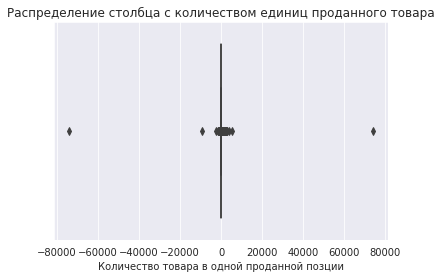

In [32]:
sns.boxplot(df['quantity'])
plt.title('Распределение столбца с количеством единиц проданного товара')
plt.xlabel('Количество товара в одной проданной позции')
pass

In [33]:
df.query('quantity > 40000 | quantity < -40000')

,purchase_id,shop_id,purchase_dt,purchase_date,product_id,price,quantity,sum,customer_id,loyal
49411,C541433,shop 0,2017-01-18 10:17:00,2017-01-18,23166,1.04,-74216,-77184.64,18025,0
69074,541431,shop 0,2017-01-18 10:01:00,2017-01-18,23166,1.04,74214,77182.56,18025,0


1. Количества товаров могут быть отрицательными и это скорее всего возвраты.
2. Видим два явных выброса, которые являются покупкой и возвратом одного и того же товара. Они уравновешивают друг друга, но очень растягивают дисперсию. К тому же - это слишком большая по количеству покупка, которая является сильным исключением из правила. Для дальнейшего анализа лучше избавимся от неё. 

In [34]:
df = df.query('quantity < 40000 & quantity > -40000')

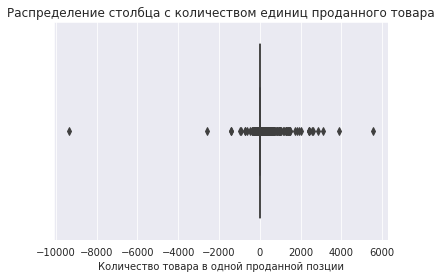

In [35]:
sns.boxplot(df['quantity'])
plt.title('Распределение столбца с количеством единиц проданного товара')
plt.xlabel('Количество товара в одной проданной позции')
pass

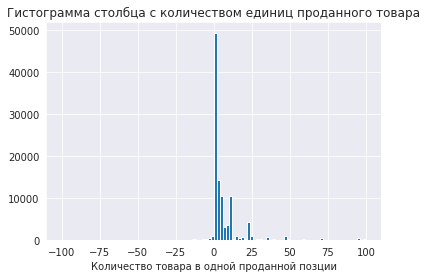

In [36]:
df['quantity'].hist(bins=100, range=(-100, 100))
plt.title('Гистограмма столбца с количеством единиц проданного товара')
plt.xlabel('Количество товара в одной проданной позции')
pass

Видим, что наибольше кол-во значений по количеству товара расположились около нуля. Что если там есть нулевые количества?

In [37]:
df.query('quantity == 0').shape[0]

33055

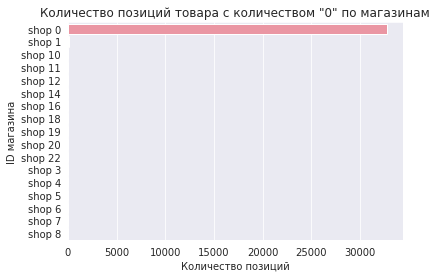

In [38]:
sns.barplot(data=df.query('quantity == 0').groupby('shop_id', as_index=False).agg({'product_id':'count'}), x='product_id', y='shop_id')
plt.title('Количество позиций товара с количеством "0" по магазинам')
plt.xlabel('Количество позиций')
plt.ylabel('ID магазина')
pass

Такие позиции есть и их очень много. Это третья часть от всего фрейма. Основная масса товаров с нулевым количеством пробита в магазине с ID "0" - очень ирончно. 

In [39]:
df[(df['quantity'] == 0) & (df['customer_id'].isna() == True)].head()

,purchase_id,shop_id,purchase_dt,purchase_date,product_id,price,quantity,sum,customer_id,loyal
6,540468,shop 0,2017-01-07 13:55:00,2017-01-07,22189,5.282000,0,0.0,NaN,0
8,538883,shop 0,2016-12-14 15:56:00,2016-12-14,22891,6.190000,0,0.0,NaN,0
23,538149,shop 0,2016-12-09 16:27:00,2016-12-09,21154,2.321667,0,0.0,NaN,0
28,539451,shop 0,2016-12-17 16:59:00,2016-12-17,22376,4.891667,0,0.0,NaN,0
32,540468,shop 0,2017-01-07 13:55:00,2017-01-07,21990,2.640000,0,0.0,NaN,0


Предположение о том, что нулевое количество - это товары, пробитые по бонусам или скидкам для владельцев карт лояльности не оправдалось. Нулевые количества товаров есть и у тех, кто не участвует в программе лояльности.

Заменить эти значения не получится а еще их очень много, поэтому просто оставим как есть, но будем иметь в виду и передадим информацию коллегам. Чтобы оценить среднее количество пробиваемого товара - посчитаем медиану по всему массиву без нулевых значений. 

In [40]:
print('Одну позицию товара в среднем пробивают в количестве {:.0f} штук'.format(df.query('quantity != 0')['quantity'].median()))

Одну позицию товара в среднем пробивают в количестве 5 штук


**Топ-10 товаров, покупаемых в самых больших количествах**

In [41]:
top10products = df.groupby('product_id', as_index=False).agg({'quantity':'sum'}).sort_values(by='quantity', ascending=False).head(10)

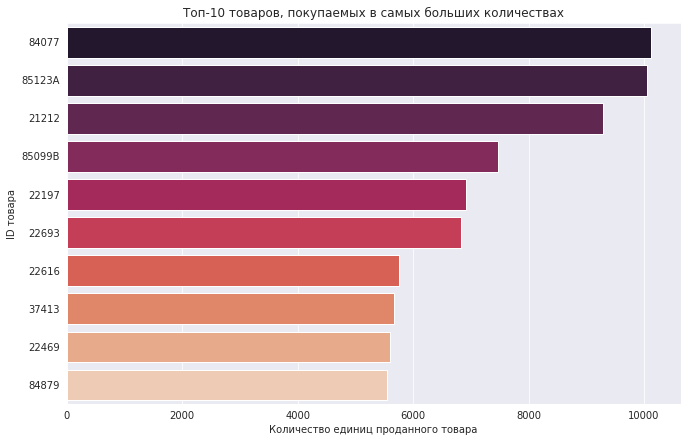

In [42]:
plt.figure(figsize = (11,7))
sns.barplot(data=top10products, x='quantity', y='product_id', palette="rocket")
plt.title('Топ-10 товаров, покупаемых в самых больших количествах')
plt.xlabel('Количество единиц проданного товара')
plt.ylabel('ID товара')
pass

За 3 месяца таких товаров купили от 5000 до 10000 штук каждого. 

**Количество чеков (продаж) по каждому магазину** 

Для следующих графиков нам потребуется дополнительный сгруппированный фрейм в котором мы объединим все наблюдения в покупки (чеки). 

In [43]:
df_grouped = df.groupby(['purchase_id'], as_index=False) \
    .agg({'shop_id':'max', 'purchase_dt':'max', 'product_id':'count', 'quantity':'mean', 'price':'mean', 'sum':'sum', 'loyal':'max', 'customer_id':'max'}) \
    .rename(columns={'product_id':'product_count', 'quantity':'mean_quantity', 'price':'mean_price', 'sum':'purchase_sum'})

In [44]:
df_grouped['mean_quantity'] = df_grouped['mean_quantity'].round(2)

In [45]:
df_grouped['mean_price'] = df_grouped['mean_price'].round(2)

In [46]:
df_grouped.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4892 entries, 0 to 4891
Data columns (total 9 columns):
purchase_id      4892 non-null object
shop_id          4892 non-null object
purchase_dt      4892 non-null datetime64[ns]
product_count    4892 non-null int64
mean_quantity    4892 non-null float64
mean_price       4892 non-null float64
purchase_sum     4892 non-null float64
loyal            4892 non-null int64
customer_id      4144 non-null Int64
dtypes: Int64(1), datetime64[ns](1), float64(3), int64(2), object(2)
memory usage: 387.0+ KB


In [47]:
purchases_per_shop = df_grouped.groupby('shop_id', as_index=False) \
    .agg({'purchase_id':'count'}) \
    .rename(columns={'purchase_id':'purchases_count'}) \
    .sort_values(by='purchases_count', ascending=False)

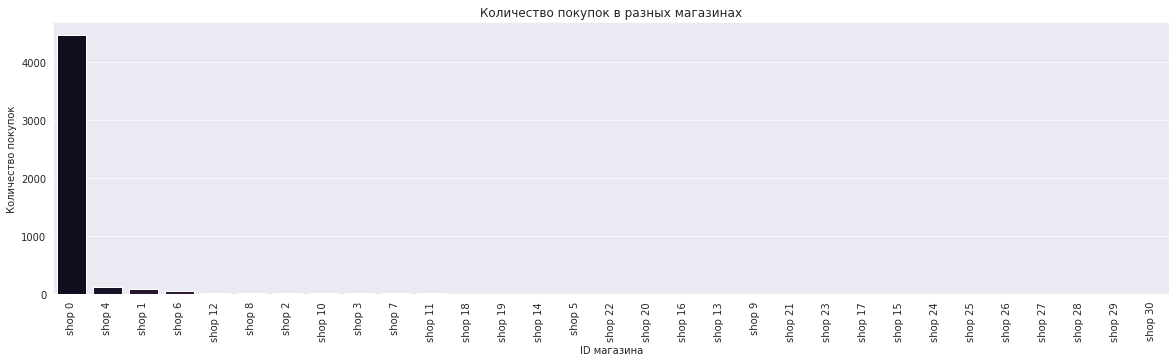

In [48]:
plt.figure(figsize = (20,5))
plt.xticks(rotation='vertical')
plt.title('Количество покупок в разных магазинах')
sns.barplot(data=purchases_per_shop, x='shop_id', y='purchases_count', palette="rocket")
plt.xlabel('ID магазина')
plt.ylabel('Количество покупок')
pass

In [49]:
print('В нашем датасете {:.0%} всех чеков приходится на Shop 0'.format(purchases_per_shop.iloc[0,1] / purchases_per_shop['purchases_count'].sum()))

В нашем датасете 91% всех чеков приходится на Shop 0


Очень интересно. Количество покупок в других магазинах по сравнению с Shop 0 просто ничтожное, а большинстве магазине - вообще сливается с нулём. Посмотрим тот же график, но без нулевого мазаина 

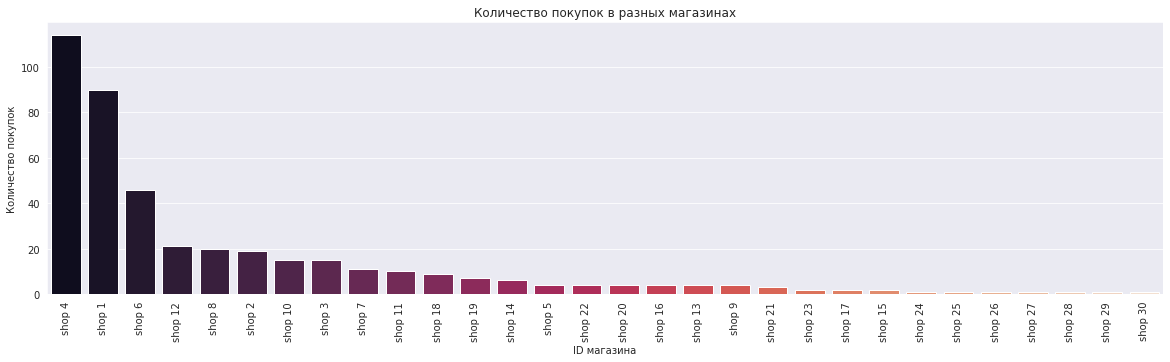

In [50]:
plt.figure(figsize = (20,5))
plt.xticks(rotation='vertical')
plt.title('Количество покупок в разных магазинах')
sns.barplot(data=purchases_per_shop[1:], x='shop_id', y='purchases_count', palette="rocket")
plt.xlabel('ID магазина')
plt.ylabel('Количество покупок')
pass

Лишь в 3 магазинах на графике мы видим больше 20 покупок. В остальных магазинах их меньше 20 за 3 месяца.

**Покупки во времени**

In [51]:
df_grouped['purchase_date'] = df_grouped['purchase_dt'].dt.date

In [52]:
purchases_per_date = df_grouped.groupby('purchase_date', as_index=False) \
    .agg({'purchase_id':'count'}) \
    .rename(columns={'purchase_id':'purchases_count'}) \
    .sort_values(by='purchase_date')

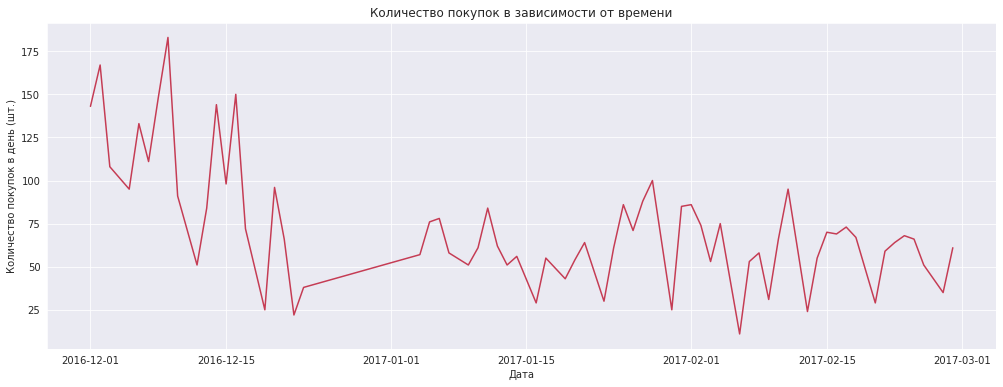

In [53]:
plt.figure(figsize = (17,6))
#plt.xticks(rotation='vertical')
plt.title('Количество покупок в зависимости от времени')
sns.lineplot(data=purchases_per_date, x='purchase_date', y='purchases_count', color="#c53c54")
plt.xlabel('Дата')
plt.ylabel('Количество покупок в день (шт.)')
pass

Видим, что количество покупок до нового года было несколько выше, чем после. 

**Средний чек**

Помним, что есть возвраты и нулевые количества (а следовательно и сумма, равная нулю), поэтому для оценки возьмем только положительные ненулевые значения суммы.

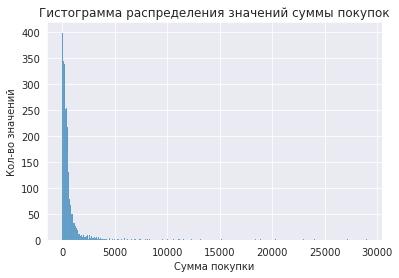

In [54]:
sns.histplot(df_grouped.query('purchase_sum > 0')['purchase_sum'])
plt.title('Гистограмма распределения значений суммы покупок')
plt.xlabel('Сумма покупки')
plt.ylabel('Кол-во значений')
pass

У распределения здоровенный хвост, но основные значения лежат в диапозоне от 0 до 2000 у.е. Для оценки среднего возьмем медиану.

In [55]:
print('Средний чек: {:.0f} у.е'.format(df_grouped.query('purchase_sum > 0')['purchase_sum'].median()))

Средний чек: 332 у.е


**Разнообразие товара в чеке | Среднее количество разных товаров в чеке**

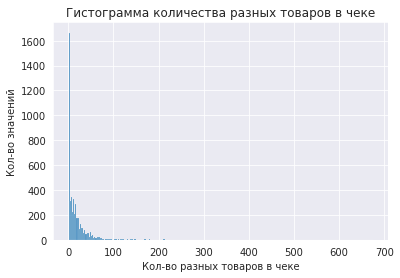

In [56]:
sns.histplot(df_grouped['product_count'])
plt.title('Гистограмма количества разных товаров в чеке')
plt.xlabel('Кол-во разных товаров в чеке')
plt.ylabel('Кол-во значений')
pass

Основные значения расположились в промежутке от 0 до 100. У распределения большой пик около нуля и длинный и незаметный хвост.
Предполгаю, что пик - это значение "1".

In [57]:
print('Самое частое значение в столбце с количеством разных позиций товара в чеке:', df_grouped['product_count'].mode()[0])

Самое частое значение в столбце с количеством разных позиций товара в чеке: 1


Так и есть. Теперь посчитаем среднее и для оценки так же возьмем медиану. 

In [58]:
print('Среднее количество разных товаров в чеке: {:.0f}'.format(df_grouped['product_count'].median()))

Среднее количество разных товаров в чеке: 10


**Средняя цена товара**

In [59]:
product_price['price'].describe()

count    3159.000000
mean        7.704377
std       165.331310
min         0.000000
25%         1.380000
50%         2.772500
75%         4.988750
max      9268.762222
Name: price, dtype: float64

In [60]:
print('В нашем датасэте {:.0f} товара с ценой равной нулю'.format(product_price.query('price == 0')['price'].count()))

В нашем датасэте 57 товара с ценой равной нулю


Даже после усреднения, у нас все равно остались товары с нулевой ценой. Значит, цена там всегда была нулевая. Скорее всего - это какие-то акционные товары, которые достаются бесплатно, но все равно пробиваются в чеке. Посмотрим на среднюю цену товара без них. 

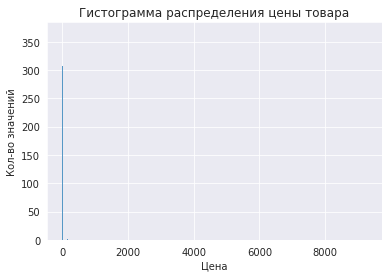

In [61]:
sns.histplot(product_price.query('price > 0')['price'])
plt.title('Гистограмма распределения цены товара')
plt.xlabel('Цена')
plt.ylabel('Кол-во значений')
pass

Судя по получившемуся графику, там есть очень сильный выброс по цене. Что там? 

In [62]:
df.query('price > 1000')

,purchase_id,shop_id,purchase_dt,purchase_date,product_id,price,quantity,sum,customer_id,loyal
1181,C537652,shop 0,2016-12-07 15:51:00,2016-12-07,AMAZONFEE,9268.762222,-2,-18537.524444,NaN,0
2637,C544589,shop 0,2017-02-21 15:11:00,2017-02-21,AMAZONFEE,9268.762222,-2,-18537.524444,NaN,0
8119,C540117,shop 0,2017-01-05 09:55:00,2017-01-05,AMAZONFEE,9268.762222,-2,-18537.524444,NaN,0
12550,537632,shop 0,2016-12-07 15:08:00,2016-12-07,AMAZONFEE,9268.762222,0,0.000000,NaN,0
24571,C537630,shop 0,2016-12-07 15:04:00,2016-12-07,AMAZONFEE,9268.762222,-2,-18537.524444,NaN,0
34815,C537651,shop 0,2016-12-07 15:49:00,2016-12-07,AMAZONFEE,9268.762222,-2,-18537.524444,NaN,0
35911,C537644,shop 0,2016-12-07 15:34:00,2016-12-07,AMAZONFEE,9268.762222,-2,-18537.524444,NaN,0
58981,C540118,shop 0,2017-01-05 09:57:00,2017-01-05,AMAZONFEE,9268.762222,-2,-18537.524444,NaN,0
59911,C537647,shop 0,2016-12-07 15:41:00,2016-12-07,AMAZONFEE,9268.762222,-2,-18537.524444,NaN,0
63101,C544587,shop 0,2017-02-21 15:07:00,2017-02-21,AMAZONFEE,9268.762222,-2,-18537.524444,NaN,0


AMAZONFEE - это комиссия за размещение Маркетплейсу? Почему её выплачивают из Shop 0? 

Но есть еще наблюдение - BANK CHARGES.

In [63]:
df.query('price > 300').sort_values(by='purchase_date').head()

,purchase_id,shop_id,purchase_dt,purchase_date,product_id,price,quantity,sum,customer_id,loyal
81548,536779,shop 0,2016-12-02 15:08:00,2016-12-02,BANK CHARGES,385.947500,0,0.000000,21502,0
1181,C537652,shop 0,2016-12-07 15:51:00,2016-12-07,AMAZONFEE,9268.762222,-2,-18537.524444,NaN,0
67898,C537600,shop 0,2016-12-07 12:41:00,2016-12-07,AMAZONFEE,9268.762222,-2,-18537.524444,NaN,0
59911,C537647,shop 0,2016-12-07 15:41:00,2016-12-07,AMAZONFEE,9268.762222,-2,-18537.524444,NaN,0
55236,C537572,shop 0,2016-12-07 12:00:00,2016-12-07,BANK CHARGES,385.947500,-2,-771.895000,NaN,0


Кроме комиссии Амазону из Shop 0 выплачивают еще и некоторые банковские сборы. Что если Shop 0 - это интернет-магазин? Он один, поэтому и индекс у него нулевой. Правда, неужели онлайн-продажи в строительной сфере настолько превышают продажи в реальных магазинах?

Что если кроме этих, есть еще какие-то специфические выплаты? Найдем последние квантили распределния и посмотрим значения product_id по ним. 

In [64]:
np.quantile(product_price.query('price > 0')['price'], [0.9, 0.95, 0.99])

array([ 8.95   , 12.65125, 27.7241 ])

In [65]:
df.query('price > 27.7241')['product_id'].unique()

array(['DOT', '22946', 'AMAZONFEE', '84078A', 'BANK CHARGES', '22828',
       'M', '22803', 'S', 'C2', '21359', '22503', '22656', '21761',
       '21769', '22827', '22655', '84616', '22833', '22929', '22823', 'D',
       '21686', '22824', 'gift_0001_40', '84963A', '20785', '84816',
       '22826', 'gift_0001_50', '22764', '84632'], dtype=object)

Есть еще "говорящие" позиции 'gift_0001_40' и 'gift_0001_50', а так же позиции с названиями DOT, M, S, D, C2. Но по их названиям вряд ли можно понять их предназначение. В остальном - больше ничего подозрительного. Будем иметь это в виду, а пока пойдем дальше. Комиссии банку и амазону нужно убрать - они будут влиять на данные и расчеты эффективности.  

In [66]:
df = df.query('price < 300')

Вернемся к средней цене. Давайте посмотрим на распределение цены по данным до 0.99 квантиля.

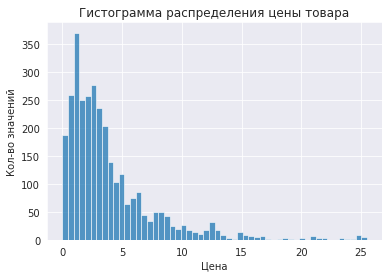

In [67]:
quantile99 = np.quantile(product_price.query('price > 0')['price'], 0.99)
sns.histplot(product_price.query('price < @quantile99')['price'])
plt.title('Гистограмма распределения цены товара')
plt.xlabel('Цена')
plt.ylabel('Кол-во значений')
pass

Гораздо лучше. Основная масса наблюдений лежит в диапозоне от 0 до 5 у.е. Хвост расходится до 25 у.е. Возьмем медиану для оценки среднего.

In [68]:
print('Средняя цена товара: {:.2f}'.format(product_price.query('price < @quantile99')['price'].median()))

Средняя цена товара: 2.77


**Количество клиентов / Доля клиентов, имеющих карту лояльности**

Для этого блока сразу сделаем агрерированный фрейм, который пригодится нам в дальнейшем. 

In [69]:
clients = df_grouped.groupby('customer_id', as_index=False) \
    .agg({'loyal':'max', 'purchase_sum':['sum', 'mean'], 'purchase_id':'count'})

In [70]:
clients.columns = ['customer_id', 'loyal', 'all_purchases_sum', 'mean_purchase', 'purchases_count']

In [71]:
clients.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1748 entries, 0 to 1747
Data columns (total 5 columns):
customer_id          1748 non-null int64
loyal                1748 non-null int64
all_purchases_sum    1748 non-null float64
mean_purchase        1748 non-null float64
purchases_count      1748 non-null int64
dtypes: float64(2), int64(3)
memory usage: 81.9 KB


In [72]:
print('Общее количество клиентов с указанным customer_id, совершивших хотя бы одну покупку за 3 месяца:', len(clients))
print('Доля клиентов с картой лояльности: {:.1%}'.format(clients['loyal'].mean()))

Общее количество клиентов с указанным customer_id, совершивших хотя бы одну покупку за 3 месяца: 1748
Доля клиентов с картой лояльности: 33.6%


**Выводы по итогам исследовательского анализа**

- Имеем данные по продажам за 3 зимних месяца (декабрь 2016, январь и февраль 2017)
- 1/3 всех наблюдений содержит НУЛЕВОЕ количество товара
- 91% от всех чеков приходится на магазин "Shop 0"
- Есть все основания предположить, что Shop 0 - это интернет-магазин
- Лишь в 4-х магазинах мы видим больше 20 чеков (покупок) за 3 месяца
- Количество покупок в последний месяц старого года несколько выше, чем после
- В датасэте 1748 клиентов с указанным id
- Среди них - 33.6% с картой лояльности

Средние
- Одну позицию товара в среднем пробивают в количестве 5 штук
- Средний чек: 332 у.е
- Среднее количество разных товаров в чеке: 10
- Средняя цена товара: 2.77 у.е.

Для дальнейшего анализа важно помнить:
- Много нулевых количеств товара
- Соответственно много нулевых сумм покупок
- Отрицательные количества - это возвраты
- Есть товары с нулевой ценой

## 4. Оценка эффективности магазинов

Посмотрим на магазины с точки зрения разных показателей и выделим лучшие из них. 

**Топ 10 магазинов по количеству покупок**

Это график мы уже строили, но учитывали там все чеки (и даже возвраты). Теперь возьмем только положительные чеки (реальные покупки), отберем только 10 лучших магазинов и покажем еще раз. Shop 0 в расчет брать не будем. 

In [73]:
purchases_per_shop = df_grouped.query('purchase_sum > 0') \
    .groupby('shop_id', as_index=False) \
    .agg({'purchase_id':'count'}) \
    .rename(columns={'purchase_id':'purchases_count'}) \
    .sort_values(by='purchases_count', ascending=False)

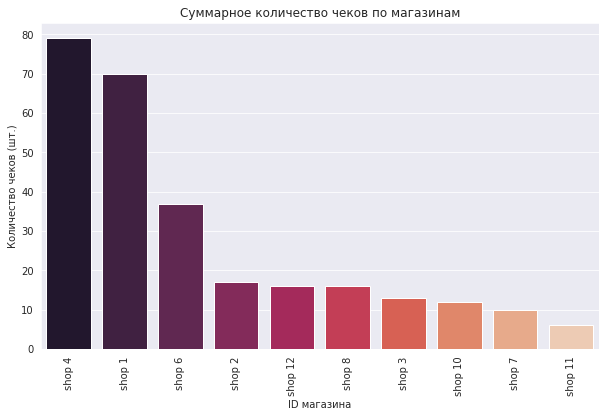

In [74]:
plt.figure(figsize = (10,6))
plt.xticks(rotation='vertical')
plt.title('Суммарное количество чеков по магазинам')
sns.barplot(data=purchases_per_shop[1:].head(10), x='shop_id', y='purchases_count', palette="rocket")
plt.xlabel('ID магазина')
plt.ylabel('Количество чеков (шт.)')
pass

С сильным отрывом первые 3 строчки занимают Shop 4, Shop 1 и Shop 6. 

**Топ-10 магазинов по среднему чеку**

In [75]:
shop_mean_purchase = df_grouped.groupby('shop_id', as_index=False) \
    .agg({'purchase_sum':'mean'}) \
    .rename(columns={'purchase_sum':'mean_purchase'}) \
    .sort_values(by='mean_purchase', ascending=False)

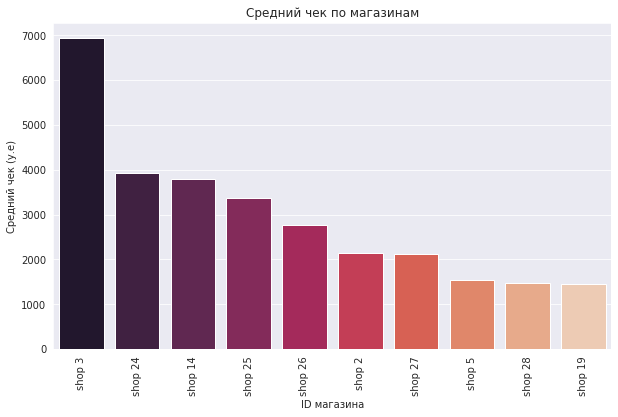

In [76]:
plt.figure(figsize = (10,6))
plt.xticks(rotation='vertical')
plt.title('Средний чек по магазинам')
sns.barplot(data=shop_mean_purchase.head(10), x='shop_id', y='mean_purchase', palette="rocket")
plt.xlabel('ID магазина')
plt.ylabel('Средний чек (у.е)')
pass

С большим отрывом лидирует Shop 3. Значения по среднему чеку там очень высокие, учитывая что средний чек по всему фрейму равен 322 у.е. Shop 0 в десятку не попал. 

**Топ 10 магазинов по наименьшему проценту возврата**

Посчитаем количество возвратов по каждому магазину. 

In [77]:
refund_rate = df_grouped.query('purchase_sum < 0') \
    .groupby('shop_id', as_index=False) \
    .agg({'purchase_id':'count'}) \
    .rename(columns={'purchase_id':'refund_count'}) \
    .sort_values(by='refund_count', ascending=True)

А затем объединим с таблицей по чекам и разделим возвраты на все чеки. 

In [78]:
refund_rate = refund_rate.merge(purchases_per_shop, on='shop_id')

In [79]:
refund_rate['refund_rate'] = (refund_rate['refund_count'] / refund_rate['purchases_count']).round(2)

In [80]:
refund_rate = refund_rate.sort_values(by='refund_rate')

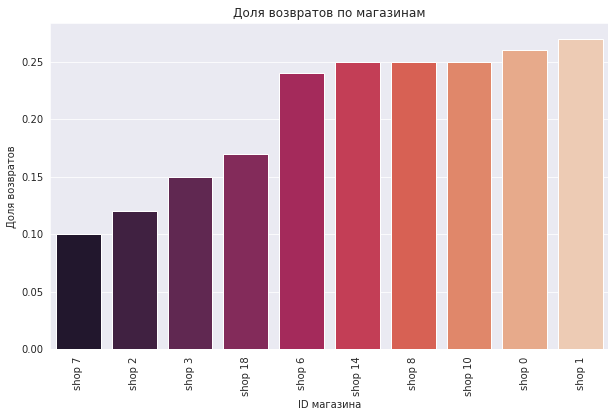

In [81]:
plt.figure(figsize = (10,6))
plt.xticks(rotation='vertical')
plt.title('Доля возвратов по магазинам')
sns.set_style("darkgrid")
sns.barplot(data=refund_rate.head(10), x='shop_id', y='refund_rate', palette="rocket")
plt.xlabel('ID магазина')
plt.ylabel('Доля возвратов')
pass

На первых строчках по этому параметру: Shop 7, Shop 2, Shop 3 и Shop 18

**10 самых прибыльных клиентов**

In [82]:
top_10_purchase_sum_clients = clients.sort_values(by='all_purchases_sum', ascending=False).head(10)

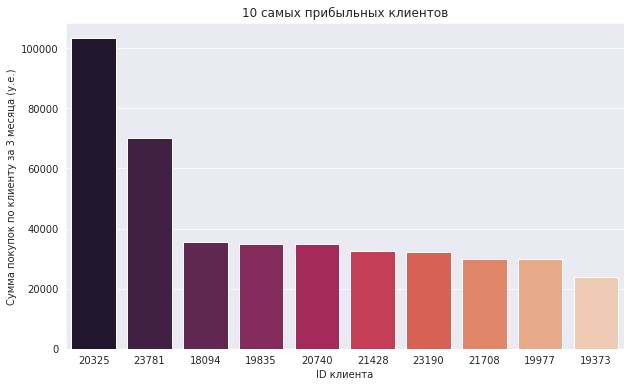

In [83]:
plt.figure(figsize = (10,6))
#plt.xticks(rotation='vertical')
plt.title('10 самых прибыльных клиентов')
sns.barplot(data=top_10_purchase_sum_clients, 
            y='all_purchases_sum', 
            x='customer_id', 
            palette="rocket", 
            order=top_10_purchase_sum_clients['customer_id'])
plt.xlabel('ID клиента')
plt.ylabel('Сумма покупок по клиенту за 3 месяца (у.е.)')
pass

Два лидера с большим отрывом - клиенты 20325 и 23781

**Топ-10 магазинов по среднемесячной выручке**

Считать будем следующим образом:
- Возвраты включены: то есть возврат уменьшает выручку
- Уберем из рассмотрения Shop 0 - он сильно изменит масштаб графика и с ним все понятно

In [84]:
#название месяца
df_grouped['purchase_month'] = df_grouped['purchase_dt'].dt.month_name()

In [85]:
#фрейм, где выручка за каждый месяц
shops_month_revenue = df_grouped.groupby(['shop_id', 'purchase_month'], as_index=False) \
    .agg({'purchase_sum':'sum'})

In [86]:
#фрейм, где среднемесячная выручка
mean_month_revenue = shops_month_revenue.groupby('shop_id', as_index=False) \
    .agg({'purchase_sum':'mean'}) \
    .rename(columns={'purchase_sum':'mean_month_revenue'}) \
    .sort_values(by='mean_month_revenue', ascending=False)

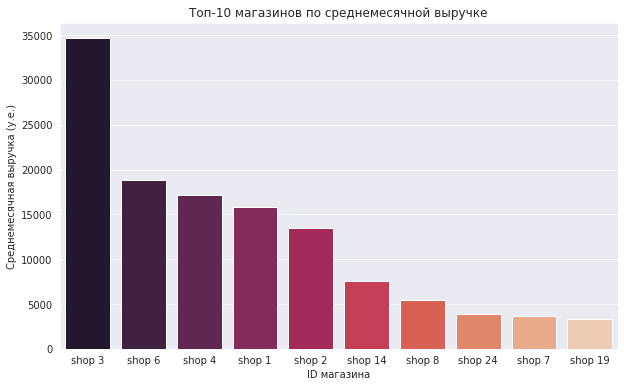

In [87]:
plt.figure(figsize = (10,6))
plt.title('Топ-10 магазинов по среднемесячной выручке')
sns.barplot(data=mean_month_revenue[1:].head(10), 
            y='mean_month_revenue', 
            x='shop_id', 
            palette="rocket")
plt.xlabel('ID магазина')
plt.ylabel('Среднемесячная выручка (у.е.)')
pass

## 5. Проверка гипотез

### Гипотеза 1. Программа лояльности работает: её участники приносят сети больше денег

Проверим эту гипотезу с помощью двух сравнений:
- Сумма чека (Гипотеза - Лояльные пользователи в среднем тратят больше)
- Количество покупок (Гипотеза - Лояльные пользователи покупают чаще)


Для удобства проверки всех гипотез напишем простенькую функцию. 

In [88]:
'''
    Функция сравнения двух выборок. 
    
    Берет на вход две выборки, выводит среднее значение по каждой и результат статистического теста (ttest)

'''

def comparative_test(sample_1, sample_1_name, sample_2, sample_2_name):
    print(sample_1_name, ': среднее - {:.2f}'.format(sample_1.mean()))
    print(sample_2_name, ': среднее - {:.2f}'.format(sample_2.mean()))
    print('T-test p_value:', st.ttest_ind(sample_1, sample_2).pvalue)

#### Сумма по чеку

Возьмем для каждого типа покупателей все суммы покупок:

- Не учитывая возвраты (отрицательные)
- Не учитывая нулевые суммы (они возникли из-за нулевых количеств товара и могут сместить среднее, если таких покупок в какой-то группе окажется больше)

In [89]:
loyal_purchases = df_grouped.query('loyal == 1  & purchase_sum > 0')['purchase_sum']
unloyal_purchases = df_grouped.query('loyal == 0  & purchase_sum > 0')['purchase_sum']

In [90]:
comparative_test(loyal_purchases, 'Лояльные клиенты', unloyal_purchases, 'Нелояльные клиенты')

Лояльные клиенты : среднее - 581.80
Нелояльные клиенты : среднее - 689.67
T-test p_value: 0.04588707434579465


Выводы противоположные ожидаемым. Средний чек по нелояльным клиентам больше, и при alpha = 0.05 мы скажем, что эти различия статистически значимые. 

Что если мы зря убрали возвраты? Может быть стоит считать вместе с ними? Попробуем.

In [91]:
loyal_purchases = df_grouped.query('loyal == 1  & purchase_sum != 0')['purchase_sum']
unloyal_purchases = df_grouped.query('loyal == 0  & purchase_sum != 0')['purchase_sum']

In [92]:
comparative_test(loyal_purchases, 'Лояльные клиенты', unloyal_purchases, 'Нелояльные клиенты')

Лояльные клиенты : среднее - 467.57
Нелояльные клиенты : среднее - 412.65
T-test p_value: 0.3696707985433558


Ситуация изменилась, но не кардинально. Мы видим, что средний чек по лояльным покупателям увеличился, но ttest говорит, что эти различия статистически незначимы. Принимаем нулевую гипотезу и говорим, что различия в средних чеках мы скорее получили случайно, а на самом деле они примерно равны. 

**Вывод**

Лояльные клиенты в среднем тратят не больше, а возможно даже меньше, чем нелояльные клиенты. 

#### Количество покупок

Проверим вторую часть гипотезы и посмотрим - покупают ли лояльные клиенты чаще, чем нелояльные. 

In [93]:
loyal_purchases_count = clients.query('loyal == 1')['purchases_count']
unloyal_purchases_count = clients.query('loyal == 0')['purchases_count']

In [94]:
comparative_test(loyal_purchases_count, 'Лояльные клиенты', unloyal_purchases_count, 'Нелояльные клиенты')

Лояльные клиенты : среднее - 2.29
Нелояльные клиенты : среднее - 2.41
T-test p_value: 0.4182681463128234


**Вывод**

Ответ кажется однозначным - нулевую гипотезу принимаем и говорим, что никаких различий в количестве покупок нет.

#### Общий вывод

С программой лояльности что-то не так. Стоит рассказать о результатах коллегам и разобраться - почему так просиходит. 

### Гипотеза 2. Модель интернета-магазина работает эффективнее, чем оффлайн-магазины

В данном случае эффективность будем измерять только средним чеком. Мы уже знаем, что по количеству покупок онлайн-магазин (Shop 0) в десятки раз превосходит другие магазины. Но, большое количество покупок не означает больше прибыли. Мы не знаем издержки. Поэтому средний чек на мой взгляд является более объективной метрикой эффективности. 

Проведем так же два теста: учитывая и не учитывая возвраты.

**Тест среднего чека без возвратов**

In [95]:
online_purchases = df_grouped.query('shop_id == "shop 0" & purchase_sum > 0 ')['purchase_sum']
offline_purchases = df_grouped.query('shop_id != "shop 0" & purchase_sum > 0 ')['purchase_sum']

In [96]:
comparative_test(online_purchases, 'Онлайн-магазин', offline_purchases, 'Оффлайн-магазины')

Онлайн-магазин : среднее - 590.15
Оффлайн-магазины : среднее - 1346.08
T-test p_value: 3.72128917866874e-18


Выводы однозначные. Проверим то же самое с возвратами. 

**Тест среднего чека с возвратами**

In [97]:
online_purchases = df_grouped.query('shop_id == "shop 0" & purchase_sum != 0 ')['purchase_sum']
offline_purchases = df_grouped.query('shop_id != "shop 0" & purchase_sum != 0 ')['purchase_sum']

In [98]:
comparative_test(online_purchases, 'Онлайн-магазин', offline_purchases, 'Оффлайн-магазины')

Онлайн-магазин : среднее - 370.50
Оффлайн-магазины : среднее - 1016.96
T-test p_value: 2.1980945139314105e-11


Ситуация не изменилась. Средние чеки просто уменьшились на примерно одинаковую величину, а разница осталась. 

**Общий вывод**

Оффлайн магазины генерируют куда больший средний чек, нежели онлайн-магазины. Однако, об оценке эффективности здесь все таки стоит говорить с осторожностью. Возможно, онлайн-магазин берет своё именно масштабами. В любом случае, о результатах этого теста тоже стоит рассказать коллегам. 

## Выводы

**В нашем распоряжении** были данные о покупках в сети строительных магазинах за 3 месяца. 

**Перед нами стояла задача** исследовать эти данные, оценить эффективность магазинов и проверить гипотезы. 

**Общие показатели:**

- Одну позицию товара в среднем пробивают в количестве 5 штук
- Средний чек: 332 у.е
- Среднее количество разных товаров в чеке: 10
- Средняя цена товара: 2.77 у.е.

**Оценка эффективности**

Рассмотрев эффективность по разным параметрам можно заметить, что на первых позициях чаще оказываются определенные магазины. А именно: Shop 4, Shop 6 и лидер - Shop 3. На Shop 3 стоит обратить внимание и посмотреть на модель его работы. По совокупности показателей он уверенно занимает первое место (наибольшая среднемесячная выручка, наибольший средний чек, низкая доля возвратов). 

**Проверка гипотез**

Мы проверили две гипотезы и вот результаты:
- Сравнивая участников программы лояльности и обычных покупателей мы не увидели статистически значимых отличий между группами ни по среднему чеку ни по количеству покупок. А в одном тесте "нелояльные" клиенты оказались даже значимо лучше. В общем - с программой лояльности что-то не так. Это стоит обсудить. 
- Во втором тесте мы сравнивали работу онлайн-магазина против оффлайн продаж. Тест по среднему чеку показал однозначное значимое отличие. Оффлайн магазины показывают куда больший средний чек. Но, думаю, что здесь не стоит сразу экстраполировать эти выводы на эффективность.

**Дополнительно стоит обсудить с коллегами, что:**
- 1/3 всех наблюдений содержит НУЛЕВОЕ количество товара
- Нужно привести в порядок датасэт с ценами на товары